In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import joblib    
import pickle
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=20

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "D:\Ishita\IGDTUW (CSE)\Summer Internship 2023\PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

(32, 256, 256, 3)
[1 0 1 1 0 0 2 1 0 0 0 0 1 1 0 0 1 1 1 1 0 0 1 0 1 0 1 1 1 0 1 1]


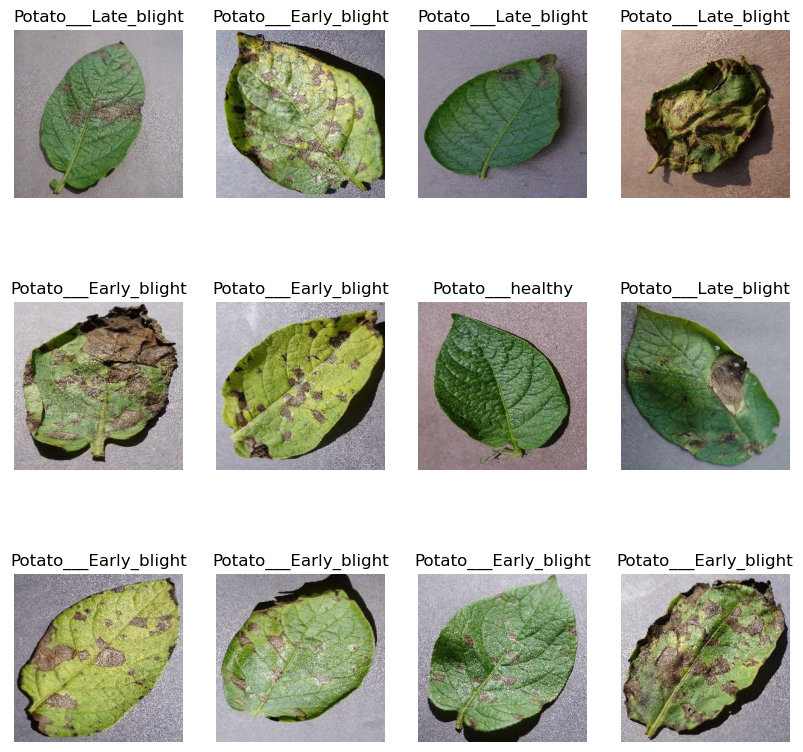

In [6]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [7]:
def get_dataset_partitions_tf(ds, train_split=0.7, val_split=0.15, test_split=0.15, shuffle=True, shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size, seed=12)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds
train_ds, val_ds, test_ds=get_dataset_partitions_tf(dataset)

In [8]:
print(len(train_ds), len(val_ds), len(test_ds))

47 10 11


In [9]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [11]:
input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes=3
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])
model.build(input_shape=input_shape)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [12]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)
history=model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/20
47/47 [==============================] - 61s 1s/step - loss: 0.8890 - accuracy: 0.4747 - val_loss: 0.7605 - val_accuracy: 0.5656
Epoch 2/20
47/47 [==============================] - 62s 1s/step - loss: 0.7318 - accuracy: 0.6343 - val_loss: 0.5778 - val_accuracy: 0.7563
Epoch 3/20
47/47 [==============================] - 62s 1s/step - loss: 0.6075 - accuracy: 0.7181 - val_loss: 0.5224 - val_accuracy: 0.7937
Epoch 4/20
47/47 [==============================] - 64s 1s/step - loss: 0.4617 - accuracy: 0.8078 - val_loss: 0.7467 - val_accuracy: 0.7406
Epoch 5/20
47/47 [==============================] - 61s 1s/step - loss: 0.4761 - accuracy: 0.7972 - val_loss: 0.4166 - val_accuracy: 0.8438
Epoch 6/20
47/47 [==============================] - 61s 1s/step - loss: 0.3440 - accuracy: 0.8451 - val_loss: 0.3463 - val_accuracy: 0.8594
Epoch 7/20
47/47 [==============================] - 61s 1s/step - loss: 0.3519 - accuracy: 0.8604 - val_loss: 0.4547 - val_accuracy: 0.8375
Epoch 8/20
47/47 [==

In [13]:
scores=model.evaluate(test_ds)
scores

11/11 [==============================] - 3s 224ms/step - loss: 0.1144 - accuracy: 0.9517


[0.11437445133924484, 0.9517045617103577]

In [14]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [15]:
history.history['loss']

[0.8889671564102173,
 0.7317736744880676,
 0.607511043548584,
 0.4617038369178772,
 0.47609418630599976,
 0.34399986267089844,
 0.35186058282852173,
 0.34155821800231934,
 0.28928282856941223,
 0.1763019561767578,
 0.13531754910945892,
 0.10883903503417969,
 0.0936744287610054,
 0.09304217249155045,
 0.07866966724395752,
 0.07561541348695755,
 0.09977082163095474,
 0.06540071964263916,
 0.10135776549577713,
 0.09234201163053513]

In [16]:
history.history['accuracy']

[0.47473403811454773,
 0.6343085169792175,
 0.7180851101875305,
 0.8078457713127136,
 0.7972074747085571,
 0.845079779624939,
 0.8603723645210266,
 0.876329779624939,
 0.8916223645210266,
 0.9375,
 0.9468085169792175,
 0.958776593208313,
 0.9621010422706604,
 0.967420220375061,
 0.9727393388748169,
 0.970079779624939,
 0.9634308218955994,
 0.9767287373542786,
 0.9634308218955994,
 0.9640957713127136]

In [17]:
history.history['val_loss']

[0.7605421543121338,
 0.577834963798523,
 0.5224472284317017,
 0.7467224597930908,
 0.4166026711463928,
 0.34634190797805786,
 0.4547388553619385,
 0.3148878216743469,
 0.3585602641105652,
 0.35545897483825684,
 0.3095848560333252,
 0.3466479480266571,
 0.10648567974567413,
 0.14579591155052185,
 0.17059780657291412,
 0.15480414032936096,
 0.2288963794708252,
 0.1916223019361496,
 0.05940403789281845,
 0.12945829331874847]

In [18]:
history.history['val_accuracy']

[0.565625011920929,
 0.7562500238418579,
 0.793749988079071,
 0.7406250238418579,
 0.84375,
 0.859375,
 0.8374999761581421,
 0.887499988079071,
 0.8500000238418579,
 0.8968750238418579,
 0.8999999761581421,
 0.887499988079071,
 0.9593750238418579,
 0.953125,
 0.956250011920929,
 0.940625011920929,
 0.9125000238418579,
 0.9375,
 0.984375,
 0.9437500238418579]

In [19]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

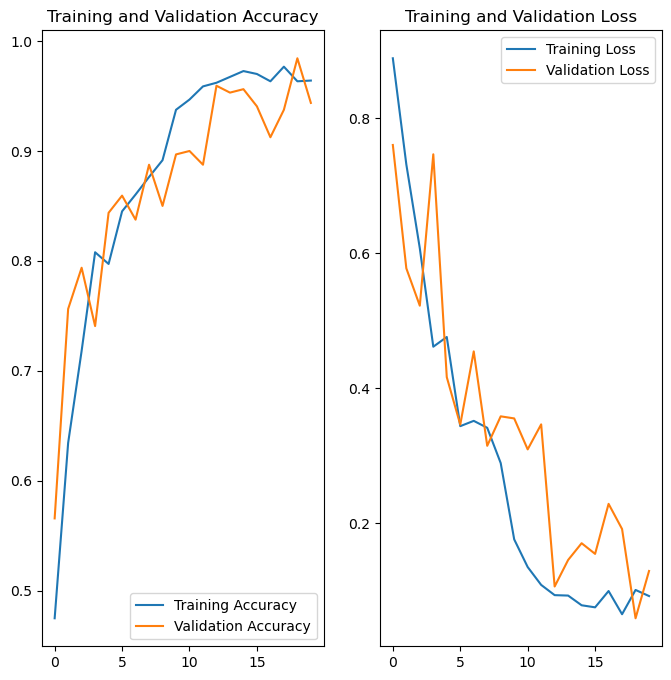

In [20]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [22]:
true_labels = []
pred_labels = []
for images_batch, labels_batch in test_ds.take(11):
    batch_prediction=model.predict(images_batch).argmax(axis=1)
    for i in labels_batch:
        true_labels.append(i)
    for i in batch_prediction:
        pred_labels.append(i)

1/1 [==============================] - 0s 317ms/step


In [23]:
def predict(model, img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)
    predictions=model.predict(img_array)
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 [==============================] - 0s 42ms/step


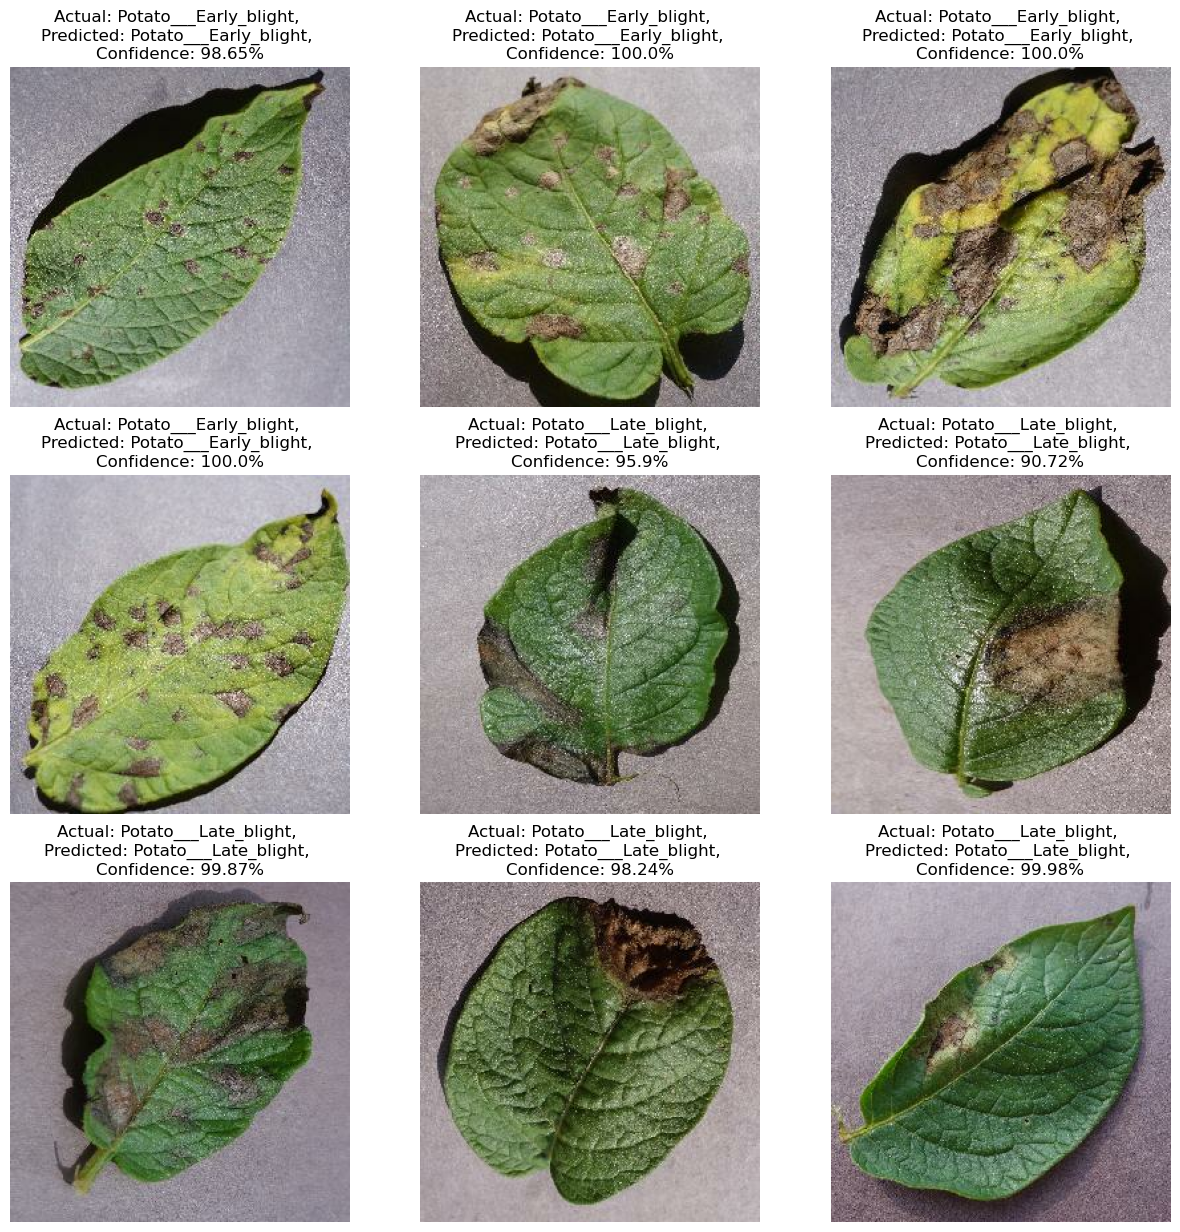

In [24]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence=predict(model,images[i].numpy())
        actual_class=class_names[labels[i]]
        plt.title(f"Actual: {actual_class}, \nPredicted: {predicted_class}, \nConfidence: {confidence}%")
        plt.axis("off")

In [25]:
print ("Classification Report: \n", classification_report(true_labels, pred_labels))

Classification Report: 
               precision    recall  f1-score   support

           0       0.92      1.00      0.96       159
           1       0.99      0.90      0.95       167
           2       0.93      0.96      0.94        26

    accuracy                           0.95       352
   macro avg       0.95      0.96      0.95       352
weighted avg       0.95      0.95      0.95       352



In [26]:
cm=tf.math.confusion_matrix(true_labels, pred_labels)
cm

<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[159,   0,   0],
       [ 14, 151,   2],
       [  0,   1,  25]])>

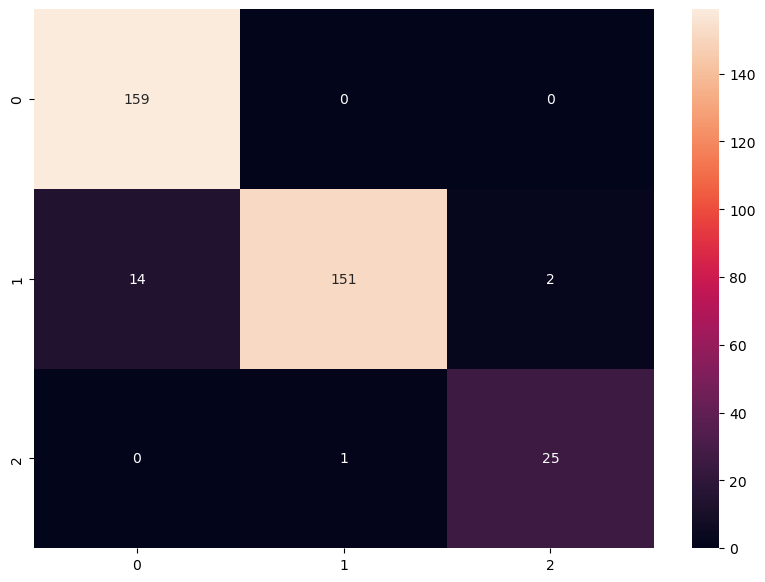

In [27]:
plt.figure(figsize=(10,7))
sn.heatmap(cm,annot=True,fmt='d')
plt.xlabel=('Predicted')
plt.ylabel=('Truth')

In [28]:
filename = "Model1-DatasetSplit70-15-15.joblib"
joblib.dump(model, filename)

['Model1-DatasetSplit70-15-15.joblib']